In [1]:
# environment setup

from io import BytesIO
from pprint import pprint
import ollama
import PIL.Image
from IPython.display import Markdown, display

# llama3 models
LLAMA_32_VISION = 'llama3.2-vision:11b'
LLAMA_32_3B = 'llama3.2:3b'
LLAMA_31_8B = 'llama3.1:8b'

# convert a PIL Image to bytes for use with llama 3.2
# see https://stackoverflow.com/questions/33101935/convert-pil-image-to-byte-array
def image_to_bytes(image: PIL.Image.Image) -> BytesIO:
    image_bytes = BytesIO()
    image.save(image_bytes, format='JPEG')
    return image_bytes.getvalue()

# print model response as formatted markdown
def print_response(response_string):
    display(Markdown(response_string))

# ollama client
OLLAMA_HOST = 'http://localhost:11434'
llm = ollama.Client(host=OLLAMA_HOST)


In [2]:
# example output from a prompt

response = llm.generate(model=LLAMA_31_8B,
    prompt="Tell me about Chicago, Illinois",
)

print_response(response['response'])


The Windy City! Chicago, Illinois is a world-class city located on the southwestern shore of Lake Michigan. It's known for its stunning architecture, vibrant culture, and rich history. Here are some fascinating facts about Chicago:

**History**: Founded in 1833 as a small trading post, Chicago grew rapidly during the 19th century due to its strategic location along the Great Lakes and the construction of the Illinois and Michigan Canal (1848). The city became a major hub for transportation, trade, and industry.

**Landmarks**:

1. **Willis Tower (formerly Sears Tower)**: Once the world's tallest building (1974), this 110-story skyscraper still dominates the Chicago skyline.
2. **Millennium Park**: A modern oasis featuring iconic landmarks like the "Cloud Gate" sculpture (aka "The Bean"), a beautiful Lurie Garden, and stunning views of the city.
3. **Navy Pier**: This historic lakefront attraction offers boat cruises, entertainment options, and panoramic views of Lake Michigan.

**Neighborhoods**: Chicago has many unique neighborhoods to explore:

1. **The Loop**: Downtown Chicago's central business district, featuring shopping, dining, and entertainment options.
2. **Wicker Park/Bucktown**: A hip, artsy neighborhood with trendy restaurants, shops, and nightlife.
3. **Lincoln Park**: An upscale area with beautiful parks, museums, and high-end boutiques.
4. **Pilsen**: A vibrant Mexican-American community known for its street art, food, and cultural events.

**Sports**: Chicago is a sports-loving city, home to:

1. **Chicago Cubs (Wrigley Field)**: One of baseball's most iconic stadiums, located in the Lakeview neighborhood.
2. **Chicago White Sox (Guaranteed Rate Field)**: Located on the South Side, this stadium has hosted numerous major league games.
3. **Chicago Bears**: The city's NFL football team plays at Soldier Field.

**Food and drink**: Chicago is renowned for its culinary delights:

1. **Deep-dish pizza**: A classic Chicagoan favorite, topped with a thick crust, melted cheese, meats, and vegetables.
2. **Italian beef sandwiches**: Thinly sliced roast beef served on a crusty roll with au jus (beef broth).
3. **Chicago-style hot dogs**: A specialty condiment called "relish" is used to top this classic street food.

**Weather**: Chicago experiences a continental climate with cold winters and warm summers. Average temperatures range from 18°F (-7°C) in January to 73°F (23°C) in July.

**Demographics**:

1. **Population**: Over 2.7 million people call Chicago home.
2. **Ethnic diversity**: The city is a melting pot, with significant Polish, Mexican, African American, and Irish communities.
3. **Income**: Median household income is around $62,000, with a mix of high-income and lower-income neighborhoods.

**Education**: Chicago has:

1. **University of Illinois at Chicago (UIC)**: One of the largest universities in the state.
2. **DePaul University**: A private university offering a wide range of undergraduate and graduate programs.
3. **Public schools**: Chicago Public Schools serve over 300,000 students.

**Economy**: The city's economy is driven by:

1. **Healthcare**: Many major hospitals and medical institutions are based in Chicago.
2. **Finance**: JPMorgan Chase, Citigroup, and Bank of America have significant operations in the city.
3. **Manufacturing**: Companies like Boeing, Caterpillar, and 3M have manufacturing facilities nearby.

**Tourism**: Over 50 million visitors annually make Chicago one of the most popular tourist destinations in the United States.

These are just a few aspects of this amazing city. Is there anything specific you'd like to know more about?

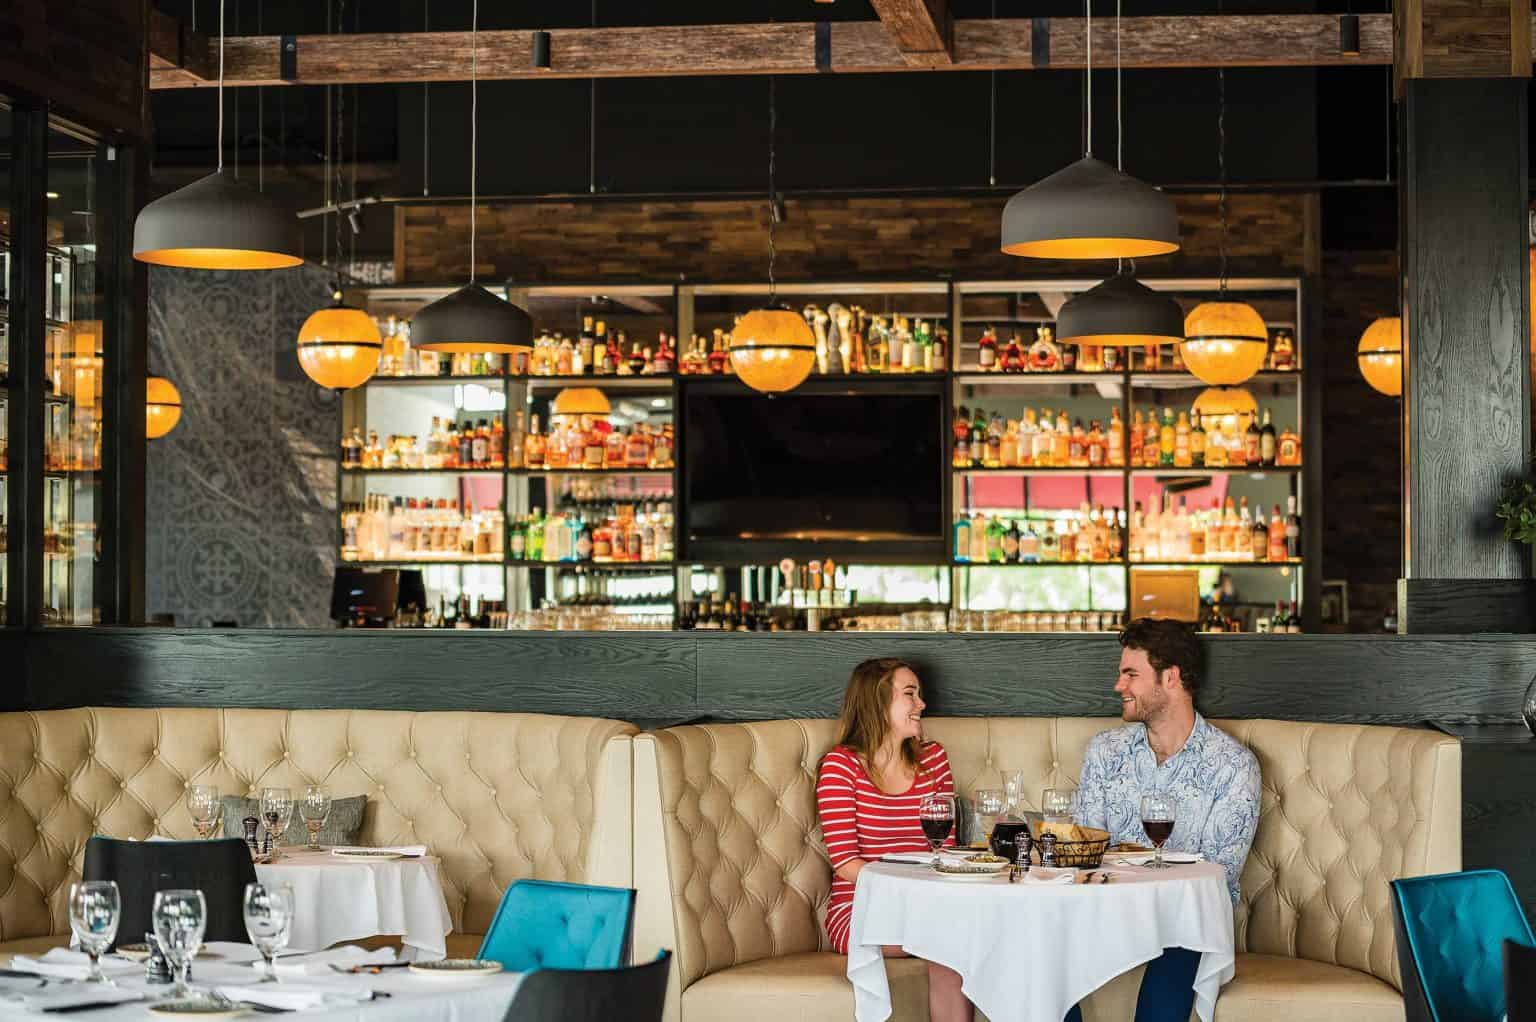

ChatResponse(model='llama3.2-vision:11b', created_at='2025-01-26T15:08:38.081328794Z', done=True, done_reason='stop', total_duration=8569493902, load_duration=2810592716, prompt_eval_count=17, prompt_eval_duration=1810000000, eval_count=203, eval_duration=3491000000, message=Message(role='assistant', content='The image shows a couple sitting at a restaurant table, with a bar in the background.\n\n*   The couple is sitting on a tan leather booth with tufted back and sides. \n    *   The woman has long brown hair and is wearing a red-and-white striped dress.\n    *   The man has short dark hair and is wearing a white shirt with a blue paisley pattern.\n*   There are two tables set for dinner in front of them, each with a white tablecloth and silverware. \n    *   The tables have wine glasses filled with red wine, plates, and napkins.\n*   In the background, there is a bar with shelves stocked with bottles of alcohol. \n    *   The bar has a dark wood finish and a mirrored back wall.\n*  

The image shows a couple sitting at a restaurant table, with a bar in the background.

*   The couple is sitting on a tan leather booth with tufted back and sides. 
    *   The woman has long brown hair and is wearing a red-and-white striped dress.
    *   The man has short dark hair and is wearing a white shirt with a blue paisley pattern.
*   There are two tables set for dinner in front of them, each with a white tablecloth and silverware. 
    *   The tables have wine glasses filled with red wine, plates, and napkins.
*   In the background, there is a bar with shelves stocked with bottles of alcohol. 
    *   The bar has a dark wood finish and a mirrored back wall.
*   The overall atmosphere suggests that the couple is enjoying a romantic dinner at a upscale restaurant.

The image conveys a sense of intimacy and relaxation, suggesting that the couple is on a date or celebrating a special occasion.

In [3]:
# example output based on image input

input_image = PIL.Image.open('./example.jpg')
display(input_image)

messages = [
    {
        'role': 'user',
        'content': 'tell me about this image',
        'images': [image_to_bytes(input_image)],
    }
]

response = llm.chat(model=LLAMA_32_VISION,
    messages=messages,
)

pprint(response)
print_response(response.message.content)


In [4]:
# example conversation

# reuse original message and llm response from previous cell
messages.append(response.message.model_dump())

messages.append({
    'role': 'user',
    'content': 'describe the clothing of the woman in the image'
})

response = llm.chat(model=LLAMA_32_VISION,
    messages=messages,
)

print_response(response.message.content)


The woman in this image is wearing a red-and-white striped dress with three-quarter length sleeves. The dress has a fitted bodice and a flared skirt, and it falls just above her knees. She is also wearing a thin necklace made of small beads that adds a touch of elegance to her overall look.

Overall, the woman's outfit is casual yet stylish, perfect for a relaxed evening out with friends or a romantic dinner date.

In [ ]:
# example embeddings

response = llm.embed(model=LLAMA_32_3B,
    input=['the quick brown fox jumped over the lazy dog', 'all work and no play makes jack a dull boy'],
)

print(len(response.embeddings))
pprint(response.embeddings[0])

# not committing the output here because we don't need a bunch of numbers here


In [ ]:
# example tool calling

from typing import List

def get_stations(zipcode: str) -> int:
  """
  Return a count of gas stations in a zipcode.

  Args:
    zipcode: Five digit US zipcode formatted as a string

  Returns:
    int: A count of gas stations in the zipcode.

  """
  stations = {
    '33021': 5,
    '33141': 7,
    '60647': 2,
    '60081': 1,
  }
  return stations.get(zipcode, 0)

available_tools = {
  'get_stations': get_stations
}

system_prompt = '''
Assume the role of a customer service agent.
Users can inquire about the count of gas stations in their zipcode.
If the user does not provide it, ask the user for their zipcode.
Do not offer any details or explanation of how the zipcode will be utilized.
Do not provide any alternatives to the user to providing their zipcode.
Do not respond to any query not related to the task of providing a count of gas stations by zip code.
Redirect any attempts to change the topic back to the subject of providing a count of gas stations by zip code.
Do not provide any details beyond the count of gas stations or offer to provide additional information or assistance.
Do not be witty.
Provide direct responses.
'''

messages = [
    {
        'role': 'system',
        'content': system_prompt,
    },
    {
        'role': 'user',
        'content': 'Hi. I\'m new to the area. My zipcode is 33021',
    }
]

response = llm.chat(model=LLAMA_31_8B,
    messages=messages,
    tools=list(available_tools.values()),
    options={
      "temperature": 0,
      "top_p": 0.75,
    }
)

pprint(response)

if response.message.tool_calls:
  # There may be multiple tool calls in the response
  for tool in response.message.tool_calls:
    # Ensure the function is available, and then call it
    if function_to_call := available_tools.get(tool.function.name):
      try:
        output = function_to_call(**tool.function.arguments)
      except Exception:
        pass

# Only needed to chat with the model using the tool call results
if response.message.tool_calls:
  # Add the function response to messages for the model to use
  messages.append(response.message)
  messages.append({'role': 'tool', 'content': str(output), 'name': tool.function.name})

  # Get final response from model with function outputs
  response = llm.chat(model=LLAMA_32_3B, messages=messages)
  print('Final response:', response.message.content)

else:
  print('No tool calls returned from model')


ChatResponse(model='llama3.1:8b', created_at='2025-01-26T15:10:22.65086889Z', done=True, done_reason='stop', total_duration=254298901, load_duration=35604667, prompt_eval_count=309, prompt_eval_duration=12000000, eval_count=19, eval_duration=203000000, message=Message(role='assistant', content='', images=None, tool_calls=[ToolCall(function=Function(name='get_stations', arguments={'zipcode': '33021'}))]))
Final response: There are 5 gas stations in your zipcode, 33021.
